In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
%load_ext autoreload
%autoreload 2

# DeepOF unsupervised pipeline: exploring the behavioral space

##### Tutorial index:
    
* Brief introduction to unsupervised analysis.
* Load your previous project.
* Running an unsupervised analysis with default parameters.
* Understanding the different available models.
* Cluster number selection.
* Temporal and global embeddings.
* Global separation dynamics.
* Exploring cluster enrichment across conditions.
* Exploring cluster dynamics across conditions.
* Interpreting clusters using SHAP.
* Exporting cluster video snippets.

### Brief introduction to unsupervised analysis

### Load your previous project

In [3]:
my_deepof_project = deepof.data.load_project("./deepof_FC_project_files/")

import pickle
with open("./deepof_FC_project_files/Coordinates/FC_dataset_experimental_conditions.pkl", "rb") as handle:
    exp_conditions = pickle.load(handle)
my_deepof_project._exp_conditions = exp_conditions

In [ ]:
# THIS SHOULD BE THE LAST SECTION OF THE FIRST TUTORIAL!

# Check scales across animals. Can we detect to which animal a given time series belongs to?
# Once happy with a solution, check that all animals show comparable cluster interpretations.

# Add preprocessing options to include multiple animals, concatenated and together in a graph

tt = my_deepof_project.get_coords(center="Center", align="Spine_1")
tt, _ = tt.preprocess(
    window_size=13,
    window_step=1,
    test_videos=1,
    scale="standard",
    handle_ids="split", # "concat" uses bps from != animals as features, "split"
)

In [18]:
# SAME HERE: Last section of the last tutorial should explore tensor and graph preprocessing
from deepof.utils import connect_mouse_topview
import networkx as nx

pp, G, to_preprocess, global_scaler = my_deepof_project.get_graph_dataset(
   # animal_id="B",
    center="Center",
    align="Spine_1",
    window_size=13,
    window_step=1,
    preprocess=True,
    scale="standard"
)

adj = nx.adjacency_matrix(G).todense()

/var/folders/wf/msmt6cvx5xl9t0p2qjd1tn65jtl6l8/T/ipykernel_47062/2788945428.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(G).todense()


In [ ]:
#What happens if we use a two-stage normalization approach?
# 1) Normalize within animals to get rid of body size effects
# 2) Normalize across animals to have similar stats across animals, and get the same clusters regardless of the animal
# ID.

### Running an unsupervised analysis with default parameters

In [ ]:
%%time
cons = my_deepof_project.deep_unsupervised_embedding(
    pp,
    adjacency_matrix=adj,
    embedding_model="VaDE",
    epochs=2,
    encoder_type="recurrent",
    n_components=15,
    latent_dim=8,
    kl_warmup=10,
    kl_annealing_mode="linear",
    batch_size=1024,
    kmeans_loss=0.0,
    reg_cat_clusters=0.0,
    # pretrained="deepof_FC_project_files/Trained_models/train_models/trained_weights/deepof_unsupervised_VaDE_recurrent_encodings_input_type=graph_kmeans_loss=0.0_encoding=8_k=15_20230126-094309_final_weights.h5",
)

In [57]:
# Load results
import pickle
with open(
    "./deepof_FC_project_files/Trained_models/train_models/deepof_unsupervised_VaDE_encoder_recurrent_encodings_input=graph_k=10_latdim=4_changepoints_False_kmeans_loss=0.0_run=1.pkl", "rb"
) as handle:
    embeddings, soft_counts, breaks = pickle.load(handle)

In [58]:
embeddings = {key:val.numpy() for key, val in embeddings.items()}
soft_counts = {key:val.numpy() for key, val in soft_counts.items()}

### Understanding the different available models

In [5]:
cons.vade.summary()

NameError: name 'cons' is not defined

### Cluster number selection

### Visualizing temporal and global embeddings

In [ ]:
# INCORPORATE AS A METHOD FOR EACH MODEL
# embeddings, soft_counts, breaks = deepof.model_utils.embedding_per_video(my_deepof_project, to_preprocess, cons)


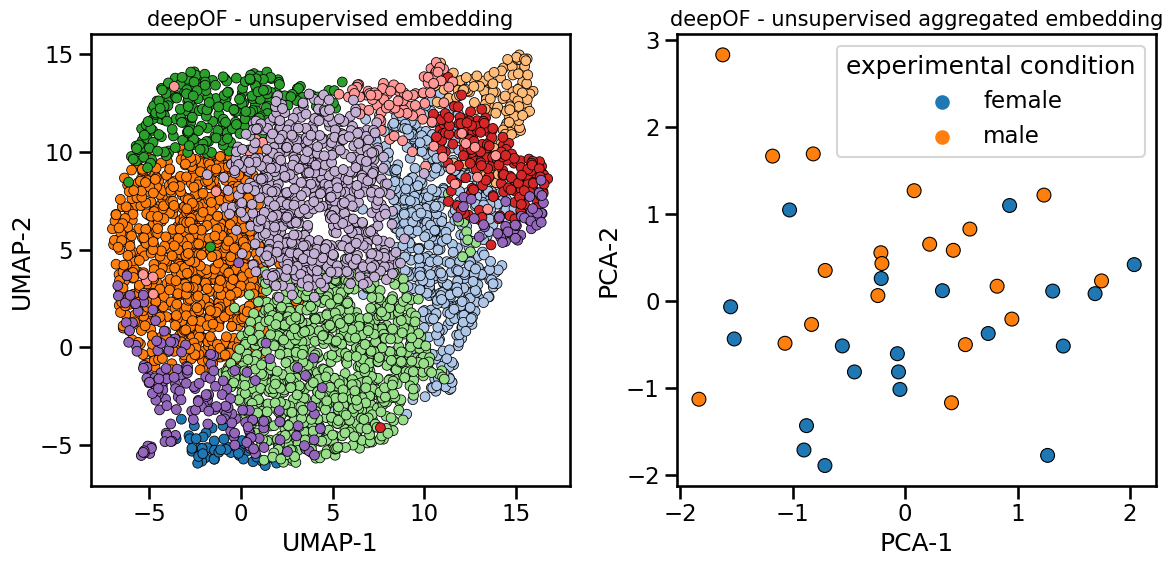

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_embeddings(
    my_deepof_project, 
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments=False,
    samples=100,
    ax=ax1,
    save=False, # Set to True, or give a custom name, to save the plot
)

deepof.visuals.plot_embeddings(
    my_deepof_project,
    embeddings, 
    soft_counts,
    breaks,
    aggregate_experiments="time on cluster",
    exp_condition="Sex",
    show_aggregated_density=False,
    ax=ax2,
    save=False, # Set to True, or give a custom name, to save the plot,
)

plt.tight_layout()
plt.show()

In [40]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
  #  animal_id="B",
    cluster_assignments=soft_counts,
    experiment_id="Test_10_FA_JB06_2_cut",
    frame_limit=60,
    selected_cluster=0,
    dpi=50,
    center="Center",
    #align="Spine_1",
    #embedding=[emb_B, emb_W],
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    embedding=embeddings,
  #  animal_id="B",
    cluster_assignments=soft_counts,
    experiment_id="Test_10_FA_JB07_cut",
    frame_limit=10,
    selected_cluster=0,
    dpi=60,
    center="Center",
    #align="Spine_1",
    #embedding=[emb_B, emb_W],
)

html = display.HTML(video)
display.display(html)
plt.close()

### Global separation dynamics

In [ ]:
# Habituation plots


### Exploring cluster enrichment across conditions

In [73]:
my_deepof_project.get_exp_conditions['Test_10_FA_JB06_2_cut'].Sex.values[0] == "female"

True

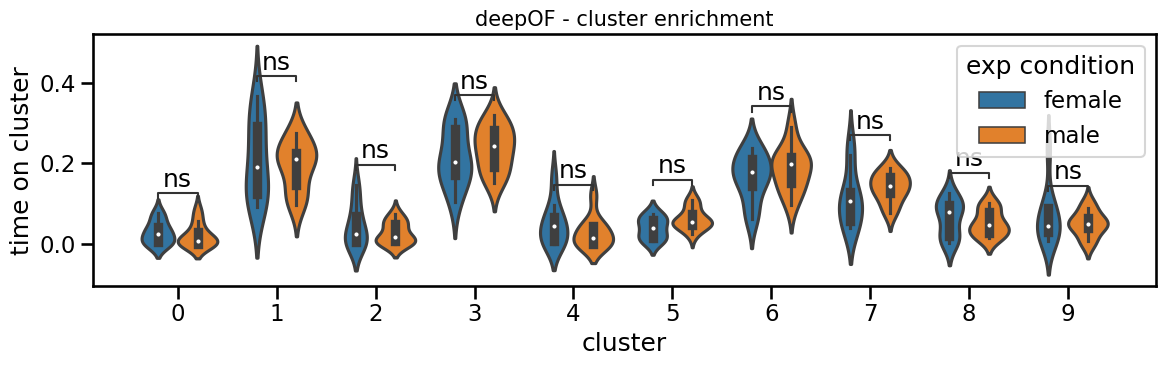

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

deepof.visuals.plot_cluster_enrichment(
    my_deepof_project,
    {key:emb for key, emb in embeddings.items() if my_deepof_project.get_exp_conditions[key].Condition.values[0] == "Nonstressed"},
    {key:sfc for key, sfc in soft_counts.items() if my_deepof_project.get_exp_conditions[key].Condition.values[0] == "Nonstressed"},
    {key:brk for key, brk in breaks.items() if my_deepof_project.get_exp_conditions[key].Condition.values[0] == "Nonstressed"},
    normalize=True,
    bin_size=1000,
    bin_index=1,
    add_stats="Mann-Whitney",
    exp_condition="Sex",
    verbose=False,
    ax=ax,
)

### Exploring cluster dynamics across conditions

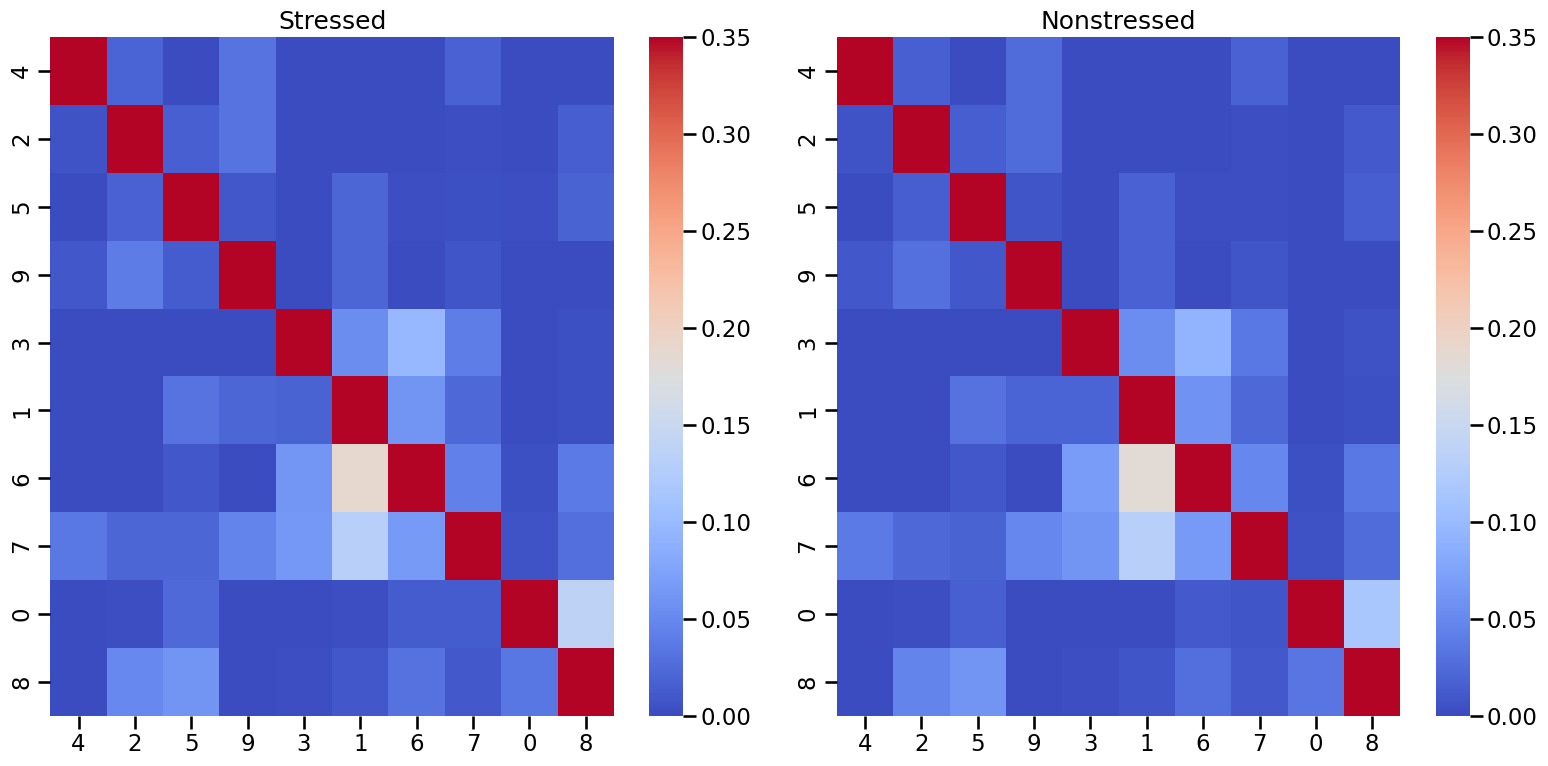

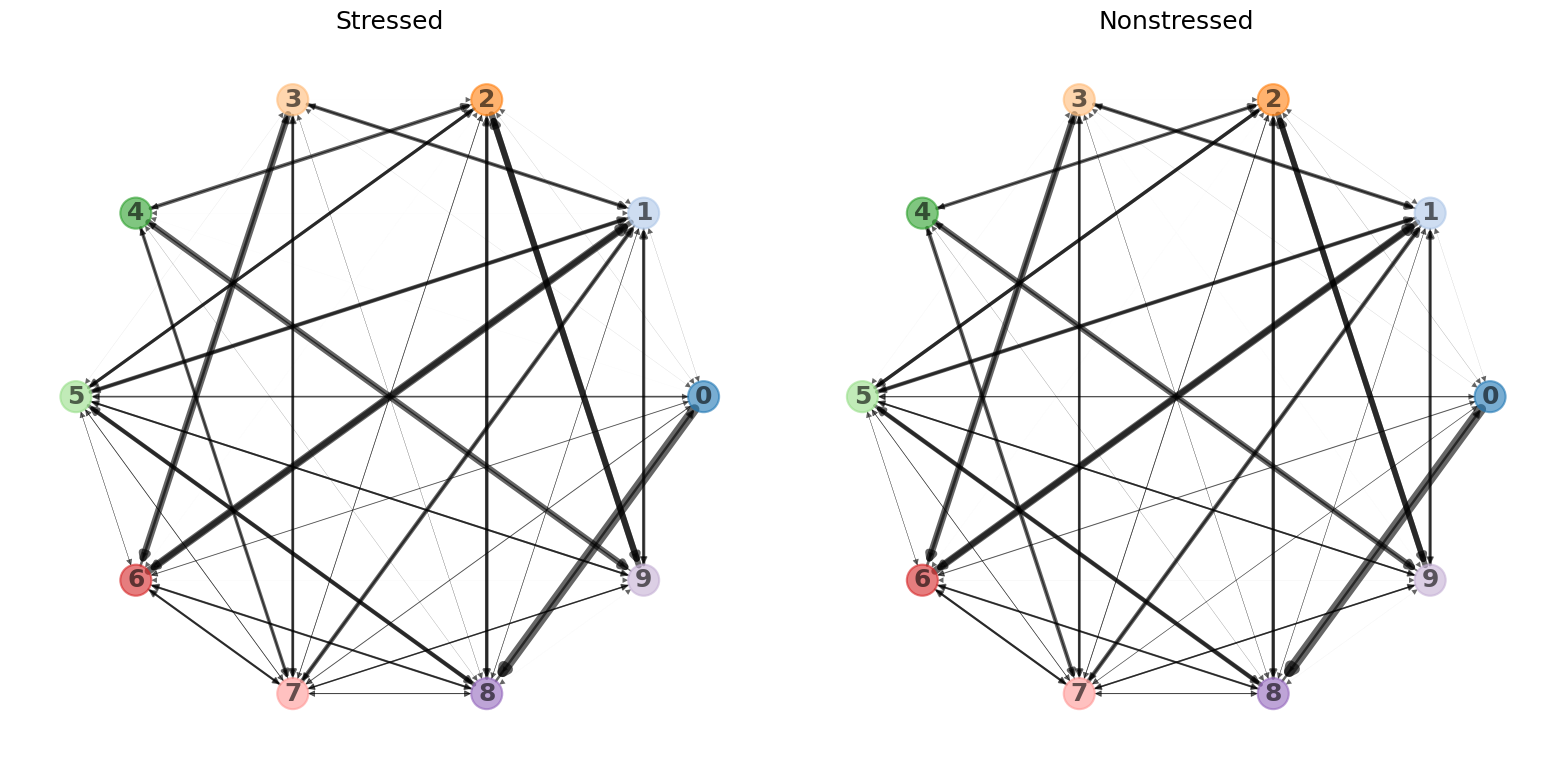

In [79]:
# Transition matrices and heatmaps
deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
   # cluster=False,
    visualization="heatmaps",
    exp_condition="Condition",
)

deepof.visuals.plot_transitions(
    my_deepof_project,
    embeddings,
    soft_counts,
    visualization="networks",
    silence_diagonal=True,
    exp_condition="Condition",
)

# TODO:

# Add option to use umap location on network plots

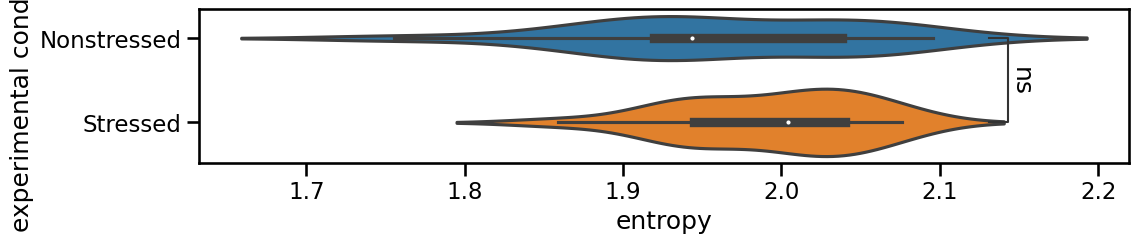

In [80]:
# Entropy plots
fig, ax = plt.subplots(1, 1, figsize=(12, 2))

deepof.visuals.plot_stationary_entropy(
    my_deepof_project,
    embeddings,
    soft_counts,
    breaks,
    exp_condition="Condition",
    ax=ax,
)

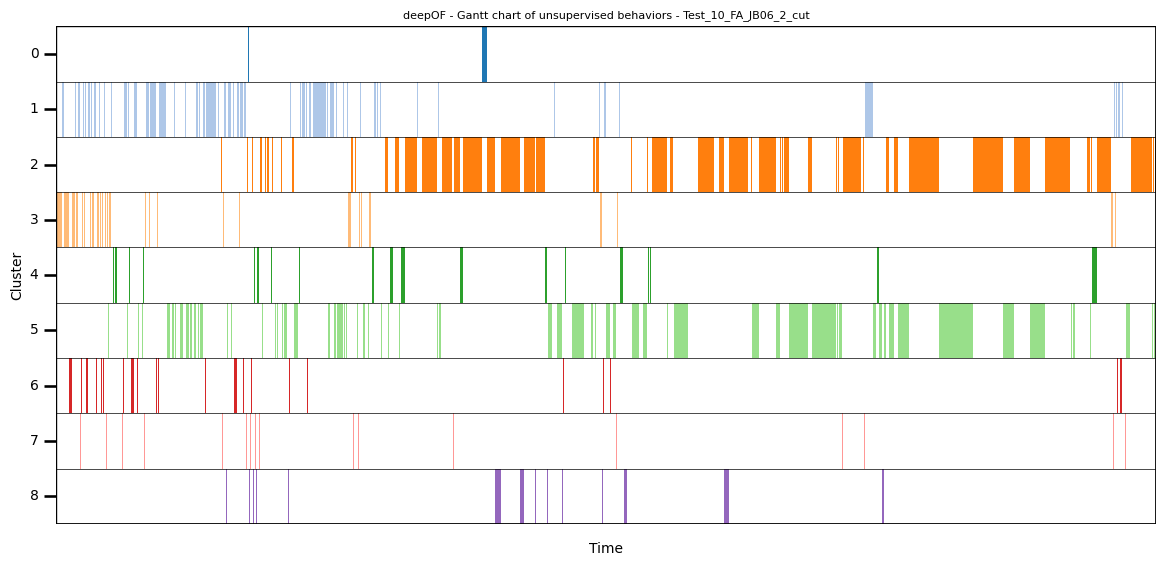

In [81]:
fig = plt.figure(figsize=(12, 6))
sns.set_context("talk")

deepof.visuals.plot_gantt(
    my_deepof_project,
    soft_counts=soft_counts,
    experiment_id="Test_10_FA_JB06_2_cut",
)

### Interpreting clusters using SHAP

In [56]:
csds_chunk_stats, hard_counts = deepof.post_hoc.annotate_time_chunks(
    deepof_project=my_deepof_project, 
    soft_counts=soft_counts, 
    breaks=breaks,
    #supervised_annotations=csds_OF_supervised_annotations,
    kin_derivative=1,
    include_distances=True,
    include_angles=True,
    include_areas=True,
    aggregate="mean",
)

KeyboardInterrupt: 

In [ ]:
csds_chunk_stats

In [ ]:
len((np.concatenate([soft for soft in soft_counts.values()])).max(axis=1))

In [ ]:
qual_filter = np.concatenate([soft for soft in soft_counts.values()]).max(axis=1) > 0.99999997
groups = deepof.post_hoc.chunk_cv_splitter(csds_chunk_stats, breaks, n_folds=6, qual_filter=qual_filter)


In [ ]:
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from catboost import CatBoostClassifier

In [ ]:
%%time
# Cross-validate GBM training across videos
cluster_clf = Pipeline([
    ("normalization", StandardScaler()),
    ("oversampling", SMOTE()),
    ("classifier", CatBoostClassifier(verbose=False)),
])
cluster_gbm_performance = cross_validate(
                              cluster_clf,
                              csds_chunk_stats.values,
                              hard_counts.values,
                              scoring=[
                                "roc_auc_ovo_weighted",
                                "roc_auc_ovr_weighted",
                              ],
                              cv=groups,
                              return_train_score=True,
                              return_estimator=True,
                              n_jobs=-1,
                             )

In [ ]:
confusion_matrices = []

for clf, fold in zip(cluster_gbm_performance["estimator"], groups):
               
    cm = confusion_matrix(
        hard_counts.values[fold[1]], clf.predict(csds_chunk_stats.values[fold[1]]), labels=np.unique(hard_counts)
    )
        
    confusion_matrices.append(cm)

In [ ]:
import pandas as pd

cluster_names = ["cluster {}".format(i) for i in range(15)]

confusion_matrix = np.stack(confusion_matrices).sum(axis=0)
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1)[:, np.newaxis]
confusion_matrix = pd.DataFrame(confusion_matrix, index=cluster_names, columns=cluster_names)

plt.figure(figsize=(16, 12))
sns.set_context("talk")

plt.title("Confusion matrix for multiclass state prediction")
sns.heatmap(confusion_matrix, annot=True, cmap="Blues")

plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("CSDS_OF_shap_confusion_matrix.pdf")

plt.show()

In [ ]:
def compute_balanced_accuracy(confusion_matrix, cluster_index):
    """
    
    Computes balanced accuracy for a specific cluster given a confusion matrx
    
    Formula: ((( TP / (TP+FN) + (TN/(TN+FP))) / 2
    
    """
    
    TP = confusion_matrix[cluster_index, cluster_index]
    FP = confusion_matrix[:, cluster_index].sum() - TP
    FN = confusion_matrix[cluster_index, :].sum() - TP
    TN = confusion_matrix.sum() - TP - FP - FN
    
    return (( TP / (TP+FN)) + (TN / (TN+FP) )) / 2

In [ ]:
from ipywidgets import interact
from collections import defaultdict

# Plot performance
@interact()
def plot_supervised_mapping_eval(metric=["balanced_accuracy"]):
    "plots supervised mapping performance across clusters"
    
    dataset = defaultdict(list)

    for cluster in range(7):
        for cm in confusion_matrices:

            ba = compute_balanced_accuracy(cm, cluster)
            dataset[cluster].append(ba)

    dataset = pd.DataFrame(dataset)
        
    plt.figure(figsize=(12, 12))
    sns.set_context("talk")
    
    plt.title("Supervised cluster mapping performance")
    
    sns.barplot(data=dataset, ci=99, color=sns.color_palette("Blues").as_hex()[-3])
    plt.axhline(1/7, linestyle="--", color="black")
    
    plt.xlabel("Cluster")
    plt.ylabel("Balanced accuracy")
    
    plt.ylim(0, 1)
    plt.savefig("CSDS_OF_shap_balanced_acc.pdf")
    
    plt.show()

In [ ]:
# Train full classifier for explainability testing
full_cluster_clf = Pipeline([
    ("oversampling", SMOTE()),
    ("classifier", CatBoostClassifier(verbose=False)),
])
full_cluster_clf.fit(
    csds_chunk_stats_filt.values,
    hard_counts_filt.values,
)

In [ ]:
data_to_explain = csds_chunk_stats_filt.sample(5000)

# Get SHAP values for the given model
explainer = shap.KernelExplainer(full_cluster_clf.predict_proba, data=shap.kmeans(csds_chunk_stats_filt, 8))
shap_values = explainer.shap_values(data_to_explain, nsamples=500)

In [ ]:
from matplotlib import colors as plt_colors

# Plot swarm plots per cluster
@interact()
def plot_shap_swarm_per_cluster(
    cluster=["all"] + list(range(7)), aggregate=False, save=False,
):

    with open("./csds_SI_cluster_shap_cat.pkl", "rb") as handle:
        shap_vals, full_clf, data_redux = pickle.load(handle)

    if aggregate:
        
        cluster_gbm_full_shap, feature_dict, agg_data = group_shap_values(csds_chunk_stats_filt, shap_vals)
        shap_vals = cluster_gbm_full_shap[fold]
        
        multi_shap_vals = [
            np.squeeze(x)
            for x in np.split(shap_vals[0], shap_vals.shape[-1], axis=-1)
        ]
        
    if cluster != "all":
        shap_vals = shap_vals[cluster]
        
    print(len(shap_vals))
        
    cmap = plt_colors.ListedColormap(np.array(["#1f77b4", "#ff7f0e"]))
    shap.summary_plot(
        shap_vals,
        (data_redux if not aggregate else agg_data),
        max_display=10,
        show=False,
        feature_names=(list(csds_chunk_stats_filt.columns) if not aggregate else list(feature_dict.keys())),
    )
    if save:
        plt.savefig(
            "csds_shap_cluster_SI={}.pdf".format(cluster),
            format="pdf",
            dpi=1000,
            bbox_inches="tight",
        )

### Exporting cluster video snippets

In [ ]:
# TODO: they should be saved to a directory that makes sense!.

In [ ]:
import pandas as pd
import os

files = [i for i in os.listdir("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/JB08_files_OF/Tables/")]

for f in files:
    cur = pd.read_hdf("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/JB08_files_OF/Tables/" + f)
    
    cur.to_csv("../../Desktop/deepOF_datasets/Tagged_videos/Data_for_deepof_OF/JB08_files_OF/Tables/" + f[:-2] + "csv")

In [ ]:
emb = cons.encoder([pp[0][:25000], pp[1][:25000]])
cls = cons.quantizer([pp[0][:25000], pp[1][:25000]])

In [ ]:
import umap
umap = umap.UMAP(
    n_components=2, 
    n_neighbors=250,
    min_dist=1.0,
).fit_transform(emb.numpy())
# umap = emb.numpy()

In [ ]:
from collections import Counter

Counter(cls.numpy().argmax(axis=1))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#tt = GaussianMixture(n_components=5, covariance_type="diag", reg_covar=1e-04).fit(emb.numpy())
#means = tt.means_
#means = cons.get_gmm_params['means'].numpy()

sns.scatterplot(x=umap[:, 0], y=umap[:, 1], hue=cls.numpy().argmax(axis=1), palette="tab20")
# means = cons.get_layer("grouper").get_layer("gaussian_mixture_latent").c_mu.numpy()
# sns.scatterplot(x=means[:,0], y=means[:,1], s=250, c="black")

plt.title("DeepOF embeddings")

# plt.legend("")
plt.show()

In [ ]:
cons.get_gmm_params['weights'].numpy().sum()

In [ ]:
tt = np.split(np.concatenate(tt), np.cumsum([i.shape[0] for k,i in vqvae_solution[0].items() if k in list(cc.keys())]))

for i in tt:
    print(i.shape)
    print(np.max(np.abs(i.mean(axis=0))))
    print(np.mean(np.abs(i.std(axis=0))))


In [ ]:
# import pickle
# import numpy as np
# with open("../train_models/deepof_unsupervised_VQVAE_encodings_input=coords_k=100_latdim=8_kmeans_loss=0.0_run=1.pkl", "rb") as handle:
#     vqvae_solution = pickle.load(handle)

In [ ]:
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from deepof.post_hoc import get_transitions
# from hmmlearn.hmm import GaussianHMM
# from tqdm import tqdm_notebook as tqdm


# def merge_and_smooth_clusters(
#     n_clusters, centroids, embedding, concat_embedding, cluster_assignments
# ):
#     """Merges the current clusters using a hierarchical agglomerative approach, and smoothens using a Gaussian HMM.

#     Args:
#         n_clusters (int): number of clusters to report.
#         centroids (np.ndarray): precomputed means per cluster.
#         embedding (tabdict): original deepof.TableDict object containing unsupervised embeddings.
#         concat_embedding (np.ndarray): concatenated list of embeddings per animal in the dataset.
#         cluster_assignments (tabdict): original deepof.TableDict object containing cluster assignments.

#     Returns:
#         new_soft_assignments (np.ndarray): concatenated postprocessed assignments for all animals in the dataset.
#     """

#     # Merge clusters ussing a hierarchical agglomerative approach
#     new_hard_assignments = AgglomerativeClustering(
#         n_clusters=n_clusters, compute_distances=True
#     ).fit_predict(centroids)
#     cluster_predictor = LinearDiscriminantAnalysis().fit(
#         centroids, new_hard_assignments
#     )
#     centroids = cluster_predictor.means_
#     new_soft_assignments = cluster_predictor.predict_proba(concat_embedding)

#     # Rebuild the soft assignments dictionary per experimental animal
#     new_soft_assignments = np.split(
#         new_soft_assignments,
#         np.cumsum([i.shape[0] for i in embedding.values()]),
#     )
#     new_soft_assignments = {
#         key: val for key, val in zip(cluster_assignments.keys(), new_soft_assignments)
#     }

#     # Smooth assignments across time using a Gaussian HMM on the embeddings, with priors based on the clustering results
#     for key, val in tqdm(new_soft_assignments.items()):

#         hmm = GaussianHMM(
#             startprob_prior=np.unique(val.argmax(axis=1), return_counts=True)[1],
#             transmat_prior=get_transitions(val.argmax(axis=1), n_states=n_clusters) + 10,
#             means_prior=centroids,
#             n_components=n_clusters,
#             covariance_type="diag",
#             n_iter=100,
#             tol=0.0001,
#         )
        
#         hmm.fit(embedding[key].numpy())
#         new_soft_assignments[key] = hmm.predict_proba(embedding[key].numpy())

#     return new_soft_assignments


# def cluster_postprocessing(embedding, cluster_assignments, n_clusters="auto"):
#     """Merges clusters using a hierarchical approach.

#     Args:
#         embedding (list): list of embeddings per animal in the dataset.
#         cluster_assignments (list): list of cluster assignments per animal in the dataset.
#         n_clusters (int): number of clusters to report.

#     Returns:
#         new_soft_assignments (list): list of new (merged) cluster assignments.

#     """
#     # Concatenate embeddings and cluster assignments in to unique np.ndarray objects
#     concat_embedding = np.concatenate([tensor.numpy() for tensor in embedding.values()])
#     hard_assignments = np.concatenate(
#         [tensor.numpy().argmax(axis=1) for tensor in cluster_assignments.values()]
#     )

#     assert concat_embedding.shape[0] == hard_assignments.shape[0]

#     # Get cluster centroids from the concatenated embeddings
#     centroids = []
#     for cluster in range(np.max(hard_assignments)):
#         centroid = concat_embedding[hard_assignments == cluster]
#         if len(centroid) == 0:
#             continue
#         centroid = np.mean(centroid, axis=0)
#         centroids.append(centroid)

#     centroids = np.stack(centroids)

#     # Merge centroids using a hierarchical approach with the given resolution, and soft-assign instances to clusters
#     if isinstance(n_clusters, int):
#         new_soft_assignments = merge_and_smooth_clusters(
#             n_clusters, centroids, embedding, concat_embedding, cluster_assignments
#         )

#     else:
#         raise NotImplementedError

#     return new_soft_assignments

In [ ]:
# from hmmlearn.hmm import GaussianHMM

# new_ass = cluster_postprocessing(
#     vqvae_solution[0], 
#     vqvae_solution[1],
#     n_clusters=12
# )
# hcc = new_ass['20191203_Day1_SI_JB08_Test_54'].argmax(axis=1)

In [ ]:
# import umap

# # Cluster on the original embedding space
# new_emb = umap.UMAP(n_components=2, n_neighbors=75).fit_transform(vqvae_solution[0]['20191203_Day1_SI_JB08_Test_54'])

# sns.scatterplot(x=new_emb[:, 0], y=new_emb[:, 1], hue=hcc, palette="tab20")

# plt.show()

In [ ]:
# # How prevalent are these clusters?
# from collections import Counter
# print(Counter(hcc))

# new_ass = hcc

In [ ]:
# # How often does the model change clusters?
# from collections import defaultdict

# lengths = defaultdict(list)
# cur = 0
# for i in range(1, len(new_ass)):
#     if new_ass[i-1] == new_ass[i]:
#         cur += 1
#     else:
#         lengths[new_ass[i-1]].append(cur)
#         cur = 1

# {key:np.mean(val) for key, val in lengths.items()}

In [ ]:
# import pandas as pd

# # Duration histograms per cluster
# lengths_df = pd.DataFrame([lengths]).melt().explode("value").astype(int)
# sns.violinplot(data=lengths_df, x="variable", y="value")

# plt.axhline(25, linestyle="--", color="black")
        
# plt.show()